# Exploring the effects of changing the g parameters

## Setup

Importage

In [4]:
import os,sys,glob,numpy as np,pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import nibabel as nib

#import hcp_utils as hcp

In [3]:
os.chdir('../')

In [6]:
!pwd

/gpfs/fs1/home/j/johngrif/johngrif/Code/libraries_of_mine/github/kcnischool2022-projectweek


In [7]:
from kspw.utils import load_stockholm_data
from kspw.pytorrww import Model_fitting,h_tf,RNNWWD,plot_fit_parameters,plot_sim_states_outputs,run_forward_model_newParas

Define some variables

In [12]:
data_dir ='data/'

Load the data

In [8]:
stuff = load_stockholm_data()
schaf_idxs,schaf_labs,schaf_rgbs,schaf_dat,subs,dwiconn_dfs,ptsrs_dfs,pcrs_dfs = stuff
subsesses = list(pcrs_dfs.keys())

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Load default parameter values

In [14]:
par_opt=np.loadtxt(data_dir +'para_optimal.txt')#[F.model.g.detach().numpy()[0], F.model.g_EE.detach().numpy()[0], F.model.g_IE.detach().numpy(), F.model.g_EI.detach().numpy(), \
         #F.model.std_in.detach().numpy(),F.model.std_out.detach().numpy()]
gain_opt = np.loadtxt(data_dir +'gain_optimal.txt')#F.model.w_bb.detach().numpy()
g_opt = par_opt[0]
g_EE_opt = par_opt[1]
g_IE_opt = par_opt[2]
g_EI_opt = par_opt[3]
std_in_opt = par_opt[4]
std_out_opt = par_opt[5]


Here we will mostly base our explorations off of one subject's SC and FC data.

First, grab that subject's data:

In [16]:
sub = subs[1]
sc = dwiconn_dfs[sub].values.copy()
sc =0.5*(sc+sc.T)
sc = np.log1p(sc)/np.linalg.norm(np.log1p(sc))
ts = ptsrs_dfs[sub,2].values.copy()
fc_emp = np.corrcoef(ts.T)

Next, initialize the model that we will then be varying

In [17]:
%%time
model = RNNWWD(input_size=2, node_size=100, batch_size=19,#3,#9,
               step_size=0.05, tr=2.5, sc=sc, fit_gains=True,
               g_mean_ini=80, g_std_ini = .1, gEE_mean_ini=2.5, gEE_std_ini = .1)

CPU times: user 2.44 ms, sys: 5.84 ms, total: 8.27 ms
Wall time: 5.94 ms


In [18]:
%%time
F = Model_fitting(model, ts, num_epochs=1)

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 26.9 µs


## Default run

First, run the model with the default parameter values

In [20]:
%%time
res = run_forward_model_newParas(F, g= g_opt, g_EE=g_EE_opt, g_IE=g_IE_opt, 
                                         g_EI=g_EI_opt, std_in= std_in_opt, 
                                         std_out=std_out_opt, w_bb=gain_opt)

0.6138823894789046
CPU times: user 17.8 s, sys: 1.54 s, total: 19.4 s
Wall time: 18.4 s


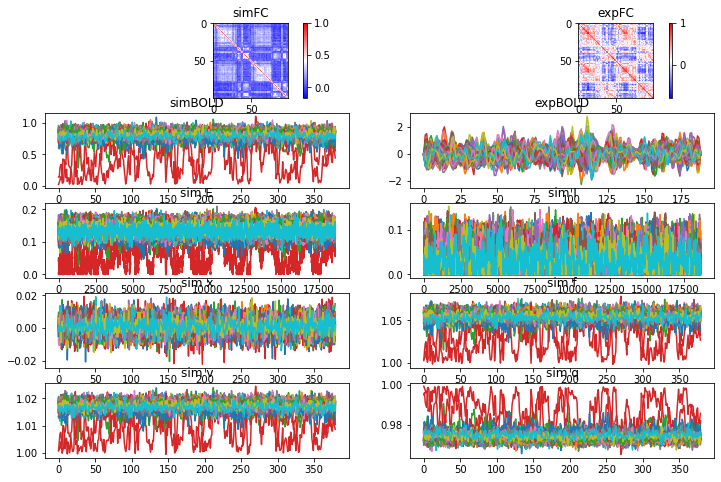

In [21]:
plot_sim_states_outputs(ts, res)

<AxesSubplot:>

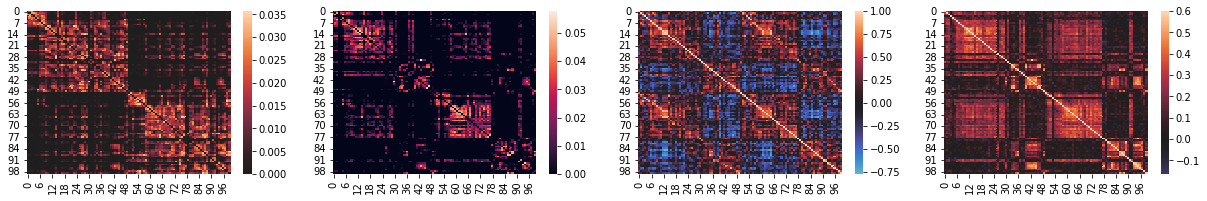

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(21,3))

a = ax[0]
sns.heatmap(sc,center=0,ax=a)

a = ax[1]
sns.heatmap(F.model.sc_m.detach(),ax=a)

a = ax[2]
sns.heatmap(np.corrcoef(ts.T),center=0,ax=a)

a = ax[3]
sns.heatmap(np.corrcoef(res['simBOLD']),center=0,ax=a,vmax=0.6)



## Vary Gei

0.6285941836779226
0.6186014513317145
0.6263905986998888
0.6190798415384648
0.6397108679758516
0.6376214912687647
0.6255720528313674
CPU times: user 2min 10s, sys: 3.43 s, total: 2min 13s
Wall time: 2min 5s


<AxesSubplot:>

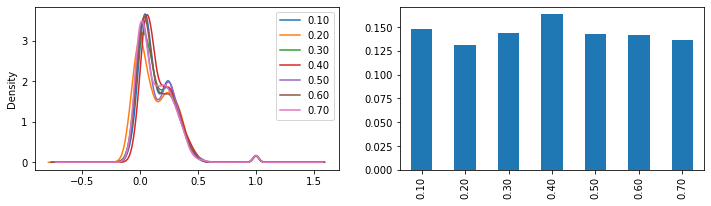

In [58]:
%%time

g_EIs = np.arange(0.1,0.8,0.1)
g_EIs

all_res_vgEI,all_simfcs_vgEI,all_simfcs_vgEI_rav = {},{},{}
for g_EI in g_EIs:
    res = run_forward_model_newParas(F, g= g_opt, g_EE=g_EE_opt, g_IE=g_IE_opt, 
                                         g_EI=g_EI, 
                                     std_in= std_in_opt, 
                                         std_out=std_out_opt, w_bb=gain_opt)
    all_res_vgEI[g_EI] = res
    
    simfc = np.corrcoef(all_res_vgEI[g_EI]['simBOLD'])
    all_simfcs_vgEI[g_EI] = simfc
    all_simfcs_vgEI_rav[g_EI] = simfc.ravel()
    
df_all_simfcs_vgEI_rav = pd.DataFrame(all_simfcs_vgEI_rav)
newcols  = ['%1.2f' %c for c in df_all_simfcs_vgEI_rav.columns]
df_all_simfcs_vgEI_rav.columns = newcols


fig, ax = plt.subplots(ncols=2, figsize=(12,3))

df_all_simfcs_vgEI_rav.plot(kind='kde',ax=ax[0])
df_all_simfcs_vgEI_rav.mean().plot(kind='bar',ax=ax[1])

## Vary Gie

0.6254596491458122
0.614524297083042
0.609512756519242
0.5878396984023841
0.6249275932630924
0.6224037971475198
0.6264779884505576
CPU times: user 2min 9s, sys: 2.7 s, total: 2min 12s
Wall time: 2min 3s


<AxesSubplot:>

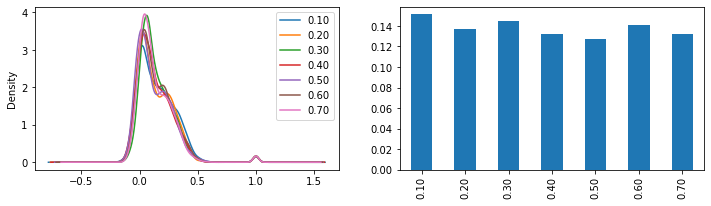

In [59]:
%%time

g_IEs = np.arange(0.1,0.8,0.1)
g_IEs

all_res_vgIE,all_simfcs_vgIE,all_simfcs_vgIE_rav = {},{},{}
for g_IE in g_IEs:
    res = run_forward_model_newParas(F, g= g_opt, g_EE=g_EE_opt, g_EI=g_EI_opt, 
                                         g_IE=g_IE, 
                                     std_in= std_in_opt, 
                                         std_out=std_out_opt, w_bb=gain_opt)
    all_res_vgIE[g_IE] = res
    
    simfc = np.corrcoef(all_res_vgIE[g_IE]['simBOLD'])
    all_simfcs_vgIE[g_IE] = simfc
    all_simfcs_vgIE_rav[g_IE] = simfc.ravel()
    
df_all_simfcs_vgIE_rav = pd.DataFrame(all_simfcs_vgIE_rav)
newcols  = ['%1.2f' %c for c in df_all_simfcs_vgIE_rav.columns]
df_all_simfcs_vgIE_rav.columns = newcols


fig, ax = plt.subplots(ncols=2, figsize=(12,3))

df_all_simfcs_vgIE_rav.plot(kind='kde',ax=ax[0])
df_all_simfcs_vgIE_rav.mean().plot(kind='bar',ax=ax[1])

0.6263911318775679
0.6346298417325015
0.6317543986778397
0.6213143197295932
0.6231246428242131
0.6254503696752155
0.6113068404170525
CPU times: user 2min 13s, sys: 4.15 s, total: 2min 17s
Wall time: 2min 8s


<AxesSubplot:>

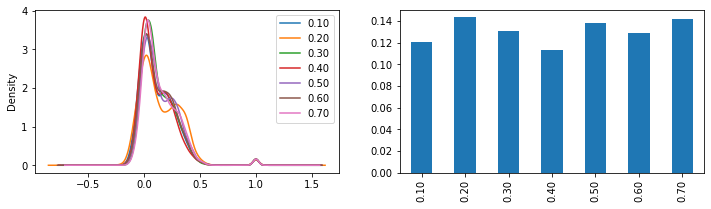

In [57]:
%%time

g_IEs = np.arange(0.1,0.8,0.1)

all_res,all_simfcs,all_simfcs_rav = {},{},{}
for g_IE in g_IEs:
    res = run_forward_model_newParas(F, g= g_opt, g_EE=g_EE_opt, g_IE=g_IE, 
                                         g_EI=g_EI_opt, std_in= std_in_opt, 
                                         std_out=std_out_opt, w_bb=gain_opt)
    all_res[g_IE] = res
    
    simfc = np.corrcoef(all_res[g_IE]['simBOLD'])
    all_simfcs[g_IE] = simfc
    all_simfcs_rav[g_IE] = simfc.ravel()
    
df_all_simfcs_rav = pd.DataFrame(all_simfcs_rav)
newcols  = ['%1.2f' %c for c in df_all_simfcs_rav.columns]
df_all_simfcs_rav.columns = newcols


fig, ax = plt.subplots(ncols=2, figsize=(12,3))

df_all_simfcs_rav.plot(kind='kde',ax=ax[0])
df_all_simfcs_rav.mean().plot(kind='bar',ax=ax[1])